# Dataset Split: Train/Val/Test with Stratification

This notebook performs **stratified splitting** of the annotated dataset from a CSV file, ensuring:
- **Video-level grouping**: All frames from the same video stay in the same split
- **Stratification**: Proportional distribution of background and target-containing videos across splits
- **Split ratio**: 70% train, 15% validation, 15% test
- **Output**: Three CSV files with image paths for use in model training

Strategy:
1. Load all images from the annotations.csv file
2. Group frames by source video
3. Classify videos as "background" (no targets) or "target" (has targets)
4. Use stratified sampling to ensure each split has balanced class proportions
5. Export train.csv, val.csv, test.csv with image paths

In [2]:
# Import Required Libraries
import os
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import defaultdict

print('✓ Libraries imported')

✓ Libraries imported


## Configuration and Paths

Update these paths to match your annotated output directory and desired CSV output location.

In [3]:
# Base project directory (used for relative pathing)
BASE_DIR = Path(r'/home/detect/DeTect_TaiwanBirds_VideoDetector')

# Input dataset CSV file (contains image_path, video_name, num_targets, etc.)
DATASET_CSV_PATH = BASE_DIR / 'dataset' / 'csvs' / 'annotations.csv'

# Output directory for split CSV files
CSV_OUTPUT_DIR = BASE_DIR / 'dataset' / 'csvs' / 'splits'
CSV_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Split ratios
TRAIN_RATIO = 0.70  # 70%
VAL_RATIO = 0.15    # 15%
TEST_RATIO = 0.15   # 15%

# Random seed for reproducibility
RANDOM_SEED = 42

print(f'Dataset CSV: {DATASET_CSV_PATH}')
print(f'Dataset CSV exists: {DATASET_CSV_PATH.exists()}')
print(f'CSV output dir: {CSV_OUTPUT_DIR}')
print(f'Split ratios: Train={TRAIN_RATIO}, Val={VAL_RATIO}, Test={TEST_RATIO}')

Dataset CSV: /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/annotations.csv
Dataset CSV exists: True
CSV output dir: /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/splits
Split ratios: Train=0.7, Val=0.15, Test=0.15


## Load Dataset from CSV

Read the annotations CSV file and prepare it for stratified splitting.

In [4]:
# Load dataset from CSV
if not DATASET_CSV_PATH.exists():
    raise FileNotFoundError(f'Dataset CSV not found: {DATASET_CSV_PATH}')

df_images = pd.read_csv(DATASET_CSV_PATH)
print(f'✓ Loaded dataset from CSV')
print(f'DataFrame shape: {df_images.shape}')
# print(f'\nColumns in dataset: {list(df_images.columns)}')

print(f'\nDataset statistics:')
print(f'  Total images: {len(df_images)}')
print(f'  Unique videos: {df_images["video_name"].nunique()}')
if 'num_targets' in df_images.columns:
    print(f'  Total targets: {df_images["num_targets"].sum()}')

df_images

✓ Loaded dataset from CSV
DataFrame shape: (10664, 10)

Dataset statistics:
  Total images: 10664
  Unique videos: 959
  Total targets: 1057


,image_path,image_width,image_height,image_format,num_targets,classes,has_annotations,video_path,video_name,frame_number
0,/home/data/F2/videos/2025-05-14/images/A03_000...,1920,1080,JPEG,0,Background,No,/home/data/F2/videos/2025-05-14/images/A03_000...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,0
1,/home/data/F2/videos/2025-05-14/images/A03_000...,1920,1080,JPEG,2,Plane,Yes,/home/data/F2/videos/2025-05-14/images/A03_000...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,124
2,/home/data/F2/videos/2025-05-14/images/A03_000...,1920,1080,JPEG,2,Plane,Yes,/home/data/F2/videos/2025-05-14/images/A03_000...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,149
3,/home/data/F2/videos/2025-05-14/images/A03_000...,1920,1080,JPEG,0,Background,No,/home/data/F2/videos/2025-05-14/images/A03_000...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,16
4,/home/data/F2/videos/2025-05-14/images/A03_000...,1920,1080,JPEG,2,Plane,Yes,/home/data/F2/videos/2025-05-14/images/A03_000...,A03_0000cfa6-1efa-350e-a754-5e23cfe9afaf,174
...,...,...,...,...,...,...,...,...,...,...
10659,/home/data/F2/videos/2025-05-14/images/A03_54d...,1920,1080,JPEG,0,Background,No,/home/data/F2/videos/2025-05-14/images/A03_54d...,A03_54decabf-d604-3afd-bcc8-736312cb36f4,224
10660,/home/data/F2/videos/2025-05-14/images/A03_54d...,1920,1080,JPEG,0,Background,No,/home/data/F2/videos/2025-05-14/images/A03_54d...,A03_54decabf-d604-3afd-bcc8-736312cb36f4,24
10661,/home/data/F2/videos/2025-05-14/images/A03_54d...,1920,1080,JPEG,0,Background,No,/home/data/F2/videos/2025-05-14/images/A03_54d...,A03_54decabf-d604-3afd-bcc8-736312cb36f4,49
10662,/home/data/F2/videos/2025-05-14/images/A03_54d...,1920,1080,JPEG,0,Background,No,/home/data/F2/videos/2025-05-14/images/A03_54d...,A03_54decabf-d604-3afd-bcc8-736312cb36f4,74


## Group Images by Video

Create a video-level dataset where each video contains all its associated frames.

In [5]:
# Group images by video
videos_dict = defaultdict(list)
for _, row in df_images.iterrows():
    video_name = row['video_name']
    videos_dict[video_name].append({
        'image_path': row['image_path'],
        'num_targets': row['num_targets'],
        'frame_number': row['frame_number']
    })

# Create video-level dataframe
video_rows = []
for video_name, frames in videos_dict.items():
    # Calculate video-level statistics
    total_targets = sum(f['num_targets'] for f in frames)
    num_frames = len(frames)
    has_targets = 'target' if total_targets > 0 else 'background'
    
    video_rows.append({
        'video_name': video_name,
        'num_frames': num_frames,
        'total_targets': total_targets,
        'video_category': has_targets,
        'frames': frames  # Store frame info for later export
    })

df_videos = pd.DataFrame(video_rows)
print(f'✓ Grouped into {len(df_videos)} unique videos')
print(f'\nVideo statistics:')
print(f'  Total frames across all videos: {len(df_images)}')
print(f'  Avg frames per video: {len(df_images) / len(df_videos):.1f}')
print(f'  Min frames: {df_videos["num_frames"].min()}, Max frames: {df_videos["num_frames"].max()}')
print(f'  Total targets: {df_videos["total_targets"].sum()}')

✓ Grouped into 959 unique videos

Video statistics:
  Total frames across all videos: 10664
  Avg frames per video: 11.1
  Min frames: 10, Max frames: 64
  Total targets: 1057


## Analyze Video Categories

Categorize videos as "background" (no targets) or "target" (has at least one target) and display category distribution.

In [6]:
# Analyze video categories
category_counts = df_videos['video_category'].value_counts()
print('Video Category Distribution:')
print(category_counts)
print()

# Calculate percentages
total_videos = len(df_videos)
for cat in ['background', 'target']:
    if cat in category_counts.index:
        count = category_counts[cat]
        pct = count / total_videos * 100
        print(f'  {cat:15s}: {count:3d} videos ({pct:5.1f}%)')

# Display stratification vector for train_test_split
print(f'\nStratification vector (used for stratified splitting):')
print(f'  This ensures each split gets balanced proportions of background vs target videos')
stratify_vector = df_videos['video_category'].values
print(f'  Vector length: {len(stratify_vector)}')
print(f'  Value counts: {pd.Series(stratify_vector).value_counts().to_dict()}')

Video Category Distribution:
video_category
background    846
target        113
Name: count, dtype: int64

  background     : 846 videos ( 88.2%)
  target         : 113 videos ( 11.8%)

Stratification vector (used for stratified splitting):
  This ensures each split gets balanced proportions of background vs target videos
  Vector length: 959
  Value counts: {'background': 846, 'target': 113}


## Stratified Video-Level Split

Perform stratified splitting to ensure proportional representation of background and target videos across all three splits (70% train, 15% val, 15% test).

**Strategy**: First split train+val (70%) from test (30%), then split train (70% of remainder) from val (30% of remainder).

In [7]:
# Reset index for clean splitting
df_videos_reset = df_videos.reset_index(drop=True)

# Step 1: Split into (train+val) 70% and (test) 30%
train_indices, test_val_indices = train_test_split(
    range(len(df_videos_reset)),
    test_size=0.30,  # 30% for test
    random_state=RANDOM_SEED,
    stratify=df_videos_reset['video_category']
)

train_df = df_videos_reset.loc[train_indices].reset_index(drop=True)
test_val_df = df_videos_reset.loc[test_val_indices].reset_index(drop=True)

# Step 2: Split the 30% into test 15% and val 15% of that portion
test_size_ratio = TEST_RATIO / (TEST_RATIO + VAL_RATIO)  # 15/(15+15)
val_indices_in_test, test_indices_in_test = train_test_split(
    range(len(test_val_df)),
    test_size=test_size_ratio,
    random_state=RANDOM_SEED,
    stratify=test_val_df['video_category']
)

test_df = test_val_df.loc[test_indices_in_test].reset_index(drop=True)
val_df = test_val_df.loc[val_indices_in_test].reset_index(drop=True)

print('✓ Stratified split complete')
print(f'\nSplit Summary:')
print(f'  Train: {len(train_df):3d} videos ({len(train_df)/len(df_videos)*100:5.1f}%)')
print(f'  Val:   {len(val_df):3d} videos ({len(val_df)/len(df_videos)*100:5.1f}%)')
print(f'  Test:  {len(test_df):3d} videos ({len(test_df)/len(df_videos)*100:5.1f}%)')
print(f'  Total: {len(train_df) + len(val_df) + len(test_df):3d} videos')

✓ Stratified split complete

Split Summary:
  Train: 671 videos ( 70.0%)
  Val:   144 videos ( 15.0%)
  Test:  144 videos ( 15.0%)
  Total: 959 videos


## Generate Split Statistics

Calculate detailed statistics for each split to verify proper stratification.

In [8]:
# Calculate statistics for each split
def calculate_split_stats(df, split_name):
    num_videos = len(df)
    num_images = sum(f['num_frames'] for _, f in df.iterrows())
    num_background_videos = (df['video_category'] == 'background').sum()
    num_target_videos = (df['video_category'] == 'target').sum()
    total_targets = df['total_targets'].sum()
    
    pct_bg = num_background_videos / num_videos * 100 if num_videos > 0 else 0
    pct_tg = num_target_videos / num_videos * 100 if num_videos > 0 else 0
    
    return {
        'split': split_name,
        'num_videos': num_videos,
        'num_images': num_images,
        'num_background_videos': num_background_videos,
        'num_target_videos': num_target_videos,
        'pct_background': pct_bg,
        'pct_target': pct_tg,
        'total_targets': total_targets
    }

stats_train = calculate_split_stats(train_df, 'Train')
stats_val = calculate_split_stats(val_df, 'Val')
stats_test = calculate_split_stats(test_df, 'Test')

stats_df = pd.DataFrame([stats_train, stats_val, stats_test])

print('\n' + '='*80)
print('DETAILED SPLIT STATISTICS')
print('='*80)
for idx, row in stats_df.iterrows():
    print(f"\n{row['split']} Set:")
    print(f"  Videos:              {row['num_videos']:4d} ({row['num_videos']/len(df_videos)*100:5.1f}% of total)")
    print(f"  Images:              {row['num_images']:4d} ({row['num_images']/len(df_images)*100:5.1f}% of total)")
    print(f"  Background videos:   {row['num_background_videos']:4d} ({row['pct_background']:5.1f}% of split)")
    print(f"  Target videos:       {row['num_target_videos']:4d} ({row['pct_target']:5.1f}% of split)")
    print(f"  Total targets:       {int(row['total_targets']):4d}")

print('\n' + '='*80)
print('Stratification Check:')
print('='*80)
overall_bg_ratio = (df_videos['video_category'] == 'background').sum() / len(df_videos) * 100
overall_tg_ratio = (df_videos['video_category'] == 'target').sum() / len(df_videos) * 100
print(f'Overall background ratio: {overall_bg_ratio:.1f}%')
print(f'Overall target ratio:     {overall_tg_ratio:.1f}%')
print()
for idx, row in stats_df.iterrows():
    print(f"{row['split']:5s} - BG: {row['pct_background']:5.1f}%, TG: {row['pct_target']:5.1f}%")


DETAILED SPLIT STATISTICS

Train Set:
  Videos:               671 ( 70.0% of total)
  Images:              7508 ( 70.4% of total)
  Background videos:    592 ( 88.2% of split)
  Target videos:         79 ( 11.8% of split)
  Total targets:        692

Val Set:
  Videos:               144 ( 15.0% of total)
  Images:              1640 ( 15.4% of total)
  Background videos:    127 ( 88.2% of split)
  Target videos:         17 ( 11.8% of split)
  Total targets:        224

Test Set:
  Videos:               144 ( 15.0% of total)
  Images:              1516 ( 14.2% of total)
  Background videos:    127 ( 88.2% of split)
  Target videos:         17 ( 11.8% of split)
  Total targets:        141

Stratification Check:
Overall background ratio: 88.2%
Overall target ratio:     11.8%

Train - BG:  88.2%, TG:  11.8%
Val   - BG:  88.2%, TG:  11.8%
Test  - BG:  88.2%, TG:  11.8%


## Export Train/Val/Test CSV Files

Create train.csv, val.csv, and test.csv files with only the image_path column.

In [9]:
# Collect all image paths for each split + export TXT/CSV with bg undersampling
from typing import Dict, List, Set

def collect_image_paths(split_df: pd.DataFrame) -> List[str]:
    """Collect all image paths from all frames in split videos."""
    image_paths: List[str] = []

    for _, row in split_df.iterrows():
        frames = row["frames"]
        for frame in frames:
            image_paths.append(frame["image_path"])
    return image_paths

def collect_image_paths_bg_undersampled(
    split_df: pd.DataFrame,
    max_bg_frames_per_video: int = 2,
    seed: int = 42,
) -> List[str]:
    """Keep all frames for target videos; for background videos, keep up to N random frames per video."""
    rng = np.random.default_rng(seed)
    out: List[str] = []
    for _, row in split_df.iterrows():
        frames = row["frames"]
        if row["video_category"] == "background":
            k = min(max_bg_frames_per_video, len(frames))
            if k <= 0:
                continue
            idxs = rng.choice(len(frames), size=k, replace=False)

            for i in idxs:
                out.append(frames[int(i)]["image_path"])
        else: # mantain all frames with targets and the max_bg_frames_per_video for bg frame in video
            for frame in frames:
                if frame["num_targets"] > 0:
                    out.append(frame["image_path"])
            # Now add random bg frames up to max_bg_frames_per_video
            bg_frames = [f for f in frames if f["num_targets"] == 0]
            k_bg = min(max_bg_frames_per_video, len(bg_frames))
            if k_bg > 0:
                bg_idxs = rng.choice(len(bg_frames), size=k_bg, replace=False)
                for i in bg_idxs:
                    out.append(bg_frames[int(i)]["image_path"])
    return out

def _resolve_image_path(p: str) -> Path:
    """Resolve image path as absolute if needed."""
    pth = Path(p)
    return pth if pth.is_absolute() else (BASE_DIR / pth)

def _infer_label_path_from_image_path(image_path: str) -> Path:
    """YOLO convention: replace /images/ with /labels/ and change suffix to .txt."""
    img_abs = _resolve_image_path(image_path)
    lbl_abs = img_abs.with_suffix(".txt")
    # Replace folder name "images" -> "labels" (both Windows and POSIX separators)
    lbl_abs = Path(str(lbl_abs).replace("\\images\\", "\\labels\\").replace("/images/", "/labels/"))
    return lbl_abs

def _read_yolo_classes(label_path: Path) -> Set[int]:
    """Parse a YOLO label file and return set of class ids."""
    if not label_path.exists():
        return set()
    classes: Set[int] = set()
    try:
        with label_path.open("r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                try:
                    classes.add(int(float(parts[0])))
                except Exception:
                    continue
    except Exception:
        return set()
    return classes

def build_per_image_df(
    split_df: pd.DataFrame,
    split_name: str,
    video_path_col: str = "video_path",

) -> pd.DataFrame:
    """Expand a video-level split_df into per-image rows with video stats + aggregated classes."""
    records: List[dict] = []
    for _, row in split_df.iterrows():
        video_name = row.get("video_name", "")
        video_num_frames = int(row.get("num_frames", len(row["frames"])))
        video_total_targets = int(row.get("total_targets", 0))
        video_category = row.get("video_category", "")

        # Prefer explicit video path if it exists in the source CSV (not present in your current annotations.csv)
        videopath = row.get(video_path_col, None)
        if videopath is None or (isinstance(videopath, float) and np.isnan(videopath)) or str(videopath).strip() == "":
            videopath = video_name

        # Aggregate classes present in this video (read from per-frame label files)
        classes_present: Set[int] = set()

        for fr in row["frames"]:
            lbl = _infer_label_path_from_image_path(fr["image_path"])
            classes_present |= _read_yolo_classes(lbl)

        classes_str = ",".join(map(str, sorted(classes_present)))

        for fr in row["frames"]:

            records.append(
                {
                    # requested fields
                    "imagepath": fr.get("image_path", ""),
                    "videopath": str(videopath),
                    "video_num_frames": video_num_frames,
                    "video_classes_present": classes_str,
                    # extra context (useful for training/analysis)
                    "video_name": video_name,
                    "video_category": video_category,
                    "video_total_targets": video_total_targets,
                    "frame_number": fr.get("frame_number", None),
                    "frame_num_targets": fr.get("num_targets", None),
                    "split": split_name,
                }

            )

    return pd.DataFrame.from_records(records)

def save_txt_imagepaths(image_paths: List[str], out_path: Path) -> None:
    """Save a TXT file with only image paths (one per line)."""
    pd.DataFrame({"image_path": image_paths}).to_csv(out_path, index=False, header=False)

# Build original (full) image lists

train_image_paths = collect_image_paths(train_df)
val_image_paths = collect_image_paths(val_df)
test_image_paths = collect_image_paths(test_df)

# Build bg-undersampled image lists (max 1 random frame per background video)
max_random_bg_frames = 1
train_image_paths_bg_us = collect_image_paths_bg_undersampled(train_df, max_bg_frames_per_video=max_random_bg_frames, seed=RANDOM_SEED + 10)
val_image_paths_bg_us = collect_image_paths_bg_undersampled(val_df, max_bg_frames_per_video=max_random_bg_frames, seed=RANDOM_SEED + 20)
test_image_paths_bg_us = collect_image_paths_bg_undersampled(test_df, max_bg_frames_per_video=max_random_bg_frames, seed=RANDOM_SEED + 30)

# Create DataFrames with only image_path (used for quick concatenations later)
train_csv_df = pd.DataFrame({"image_path": train_image_paths})
val_csv_df = pd.DataFrame({"image_path": val_image_paths})
test_csv_df = pd.DataFrame({"image_path": test_image_paths})

train_bg_us_df = pd.DataFrame({"image_path": train_image_paths_bg_us})
val_bg_us_df = pd.DataFrame({"image_path": val_image_paths_bg_us})
test_bg_us_df = pd.DataFrame({"image_path": test_image_paths_bg_us})

# Save TXT files (image paths only)
train_txt_path = CSV_OUTPUT_DIR / "train.txt"
val_txt_path = CSV_OUTPUT_DIR / "val.txt"
test_txt_path = CSV_OUTPUT_DIR / "test.txt"

save_txt_imagepaths(train_image_paths, train_txt_path)
save_txt_imagepaths(val_image_paths, val_txt_path)
save_txt_imagepaths(test_image_paths, test_txt_path)

# Save bg-undersampled TXT files
train_bg_us_txt_path = CSV_OUTPUT_DIR / "train_bg_undersampled.txt"
val_bg_us_txt_path = CSV_OUTPUT_DIR / "val_bg_undersampled.txt"
test_bg_us_txt_path = CSV_OUTPUT_DIR / "test_bg_undersampled.txt"

save_txt_imagepaths(train_image_paths_bg_us, train_bg_us_txt_path)
save_txt_imagepaths(val_image_paths_bg_us, val_bg_us_txt_path)
save_txt_imagepaths(test_image_paths_bg_us, test_bg_us_txt_path)

print("✓ TXT files exported (image paths only)")

print(f"  {train_txt_path}  ({len(train_image_paths)} rows)")
print(f"  {val_txt_path}    ({len(val_image_paths)} rows)")
print(f"  {test_txt_path}   ({len(test_image_paths)} rows)")

print()

print("✓ BG-undersampled TXT files exported (max 2 bg frames/video)")

print(f"  {train_bg_us_txt_path}  ({len(train_image_paths_bg_us)} rows)")
print(f"  {val_bg_us_txt_path}    ({len(val_image_paths_bg_us)} rows)")
print(f"  {test_bg_us_txt_path}   ({len(test_image_paths_bg_us)} rows)")

# Save CSV files with all information (per-image)
train_csv_path = CSV_OUTPUT_DIR / "train.csv"
val_csv_path = CSV_OUTPUT_DIR / "val.csv"
test_csv_path = CSV_OUTPUT_DIR / "test.csv"

train_images_full_df = build_per_image_df(train_df, "train")
val_images_full_df = build_per_image_df(val_df, "val")
test_images_full_df = build_per_image_df(test_df, "test")

train_images_full_df.to_csv(train_csv_path, index=False)
val_images_full_df.to_csv(val_csv_path, index=False)
test_images_full_df.to_csv(test_csv_path, index=False)

print()

print("✓ CSV files exported (per-image, full information)")

print(f"  {train_csv_path}  ({len(train_images_full_df)} rows)")
print(f"  {val_csv_path}    ({len(val_images_full_df)} rows)")
print(f"  {test_csv_path}   ({len(test_images_full_df)} rows)")

# Verify no duplicates across splits (FULL)

all_paths_full = set(train_image_paths + val_image_paths + test_image_paths)
total_paths_full = len(train_image_paths) + len(val_image_paths) + len(test_image_paths)

if len(all_paths_full) == total_paths_full:
    print("\n✓ No image duplicates across FULL splits")
else:
    print("\n⚠ WARNING: Found duplicate images across FULL splits!")

# Verify all images are included

if len(all_paths_full) == len(df_images):
    print(f"✓ All {len(df_images)} images are included in FULL splits")

# Verify no duplicates across splits (UNDERSAMPLED)
all_paths_us = set(train_image_paths_bg_us + val_image_paths_bg_us + test_image_paths_bg_us)
total_paths_us = len(train_image_paths_bg_us) + len(val_image_paths_bg_us) + len(test_image_paths_bg_us)

if len(all_paths_us) == total_paths_us:
    print("✓ No image duplicates across UNDERSAMPLED splits")

else:
    print("⚠ WARNING: Found duplicate images across UNDERSAMPLED splits!")


✓ TXT files exported (image paths only)
  /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/splits/train.txt  (7508 rows)
  /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/splits/val.txt    (1640 rows)
  /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/splits/test.txt   (1516 rows)

✓ BG-undersampled TXT files exported (max 2 bg frames/video)
  /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/splits/train_bg_undersampled.txt  (1269 rows)
  /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/splits/val_bg_undersampled.txt    (322 rows)
  /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/splits/test_bg_undersampled.txt   (257 rows)

✓ CSV files exported (per-image, full information)
  /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/splits/train.csv  (7508 rows)
  /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/splits/val.csv    (1640 rows)
  /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/splits/test

In [10]:
# Save per-video summary CSVs (one row per video) including classes present

CLASS_ID_TO_NAME = {
    0: "Bat",
    1: "Bird",
    2: "Insect",
    3: "Drone",
    4: "Plane",
    5: "Other",
    6: "Unknown",
}

def _ensure_label_helpers_for_video_exports() -> None:
    # Allow running this cell standalone after a kernel restart
    if "_resolve_image_path" not in globals():
        def _resolve_image_path(p: str) -> Path:
            pth = Path(p)
            return pth if pth.is_absolute() else (BASE_DIR / pth)
        globals()["_resolve_image_path"] = _resolve_image_path

    if "_infer_label_path_from_image_path" not in globals():
        def _infer_label_path_from_image_path(image_path: str) -> Path:
            img_abs = globals()["_resolve_image_path"](image_path)
            lbl_abs = img_abs.with_suffix(".txt")
            lbl_abs = Path(str(lbl_abs).replace("\\images\\", "\\labels\\").replace("/images/", "/labels/"))
            return lbl_abs
        globals()["_infer_label_path_from_image_path"] = _infer_label_path_from_image_path

    if "_read_yolo_classes" not in globals():
        def _read_yolo_classes(label_path: Path) -> Set[int]:
            if not label_path.exists():
                return set()
            out: Set[int] = set()
            try:
                with label_path.open("r", encoding="utf-8") as f:
                    for line in f:
                        line = line.strip()
                        if not line:
                            continue
                        parts = line.split()
                        if not parts:
                            continue
                        try:
                            out.add(int(float(parts[0])))
                        except Exception:
                            continue
            except Exception:
                return set()
            return out
        globals()["_read_yolo_classes"] = _read_yolo_classes

_ensure_label_helpers_for_video_exports()

def build_per_video_df(split_df: pd.DataFrame, split_name: str) -> pd.DataFrame:

    rows: List[dict] = []

    for _, row in split_df.iterrows():
        frames = row["frames"]
        video_name = row.get("video_name", "")
        num_frames = int(row.get("num_frames", len(frames)))
        total_targets = int(row.get("total_targets", 0))
        video_category = row.get("video_category", "")

        # Aggregate class ids from label files of all frames
        classes_present: Set[int] = set()

        for fr in frames:
            lbl = _infer_label_path_from_image_path(fr["image_path"])
            classes_present |= _read_yolo_classes(lbl)

        class_ids_sorted = sorted(classes_present)
        class_ids_str = ",".join(map(str, class_ids_sorted))
        class_names = [CLASS_ID_TO_NAME.get(i, f"Class_{i}") for i in class_ids_sorted]
        class_names_str = ",".join(class_names)

        videopath = row.get("video_path", None)
        if videopath is None or (isinstance(videopath, float) and np.isnan(videopath)) or str(videopath).strip() == "":
            videopath = video_name
        rows.append(
            {
                "split": split_name,
                "video_name": video_name,
                "videopath": str(videopath),
                "num_frames": num_frames,
                "total_targets": total_targets,
                "video_category": video_category,
                "classes_present_ids": class_ids_str,
                "classes_present_names": class_names_str,
            }
        )
    return pd.DataFrame(rows)

train_videos_csv_path = CSV_OUTPUT_DIR / "train_videos.csv"
val_videos_csv_path = CSV_OUTPUT_DIR / "val_videos.csv"
test_videos_csv_path = CSV_OUTPUT_DIR / "test_videos.csv"

train_videos_df = build_per_video_df(train_df, "train")
val_videos_df = build_per_video_df(val_df, "val")
test_videos_df = build_per_video_df(test_df, "test")

train_videos_df.to_csv(train_videos_csv_path, index=False)
val_videos_df.to_csv(val_videos_csv_path, index=False)
test_videos_df.to_csv(test_videos_csv_path, index=False)
print("✓ Video-level CSV files exported (with classes present)")
print(f"  {train_videos_csv_path}  ({len(train_videos_df)} rows)")
print(f"  {val_videos_csv_path}    ({len(val_videos_df)} rows)")
print(f"  {test_videos_csv_path}   ({len(test_videos_df)} rows)")

✓ Video-level CSV files exported (with classes present)
  /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/splits/train_videos.csv  (671 rows)
  /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/splits/val_videos.csv    (144 rows)
  /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/splits/test_videos.csv   (144 rows)


,class_id,class_name,train_videos,val_videos,test_videos
0,0,Bat,1,1,0
1,1,Bird,44,3,5
2,2,Insect,4,0,1
3,3,Drone,0,0,0
4,4,Plane,11,5,5
5,5,Other,1,1,1
6,6,Unknown,21,7,6


Class 0 (Bat): train=1, val=1, test=0
Class 1 (Bird): train=44, val=3, test=5
Class 2 (Insect): train=4, val=0, test=1
Class 3 (Drone): train=0, val=0, test=0
Class 4 (Plane): train=11, val=5, test=5
Class 5 (Other): train=1, val=1, test=1
Class 6 (Unknown): train=21, val=7, test=6


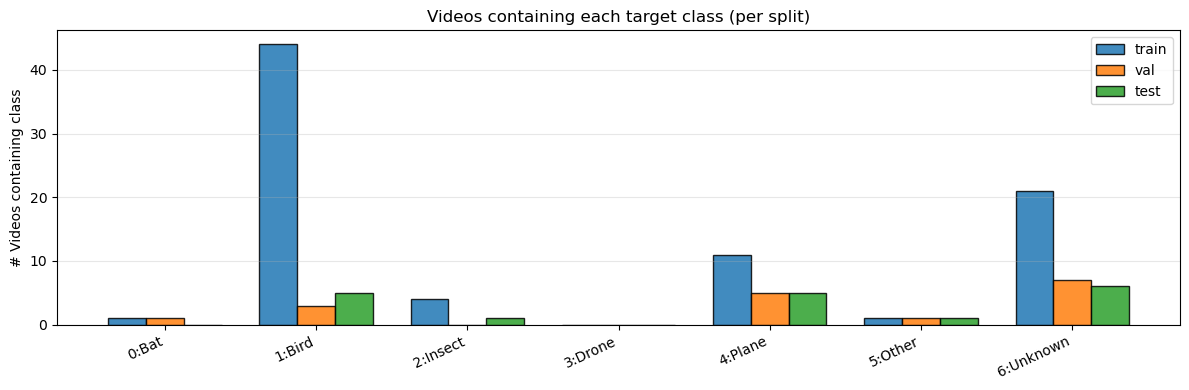

In [11]:
# Visualization: how many videos include each target class (per split)
def _parse_class_ids(s: str) -> Set[int]:
    if s is None or (isinstance(s, float) and np.isnan(s)):
        return set()
    s = str(s).strip()
    if not s:
        return set()
    out: Set[int] = set()
    for part in s.split(","):
        part = part.strip()
        if not part:
            continue
        try:
            out.add(int(part))
        except Exception:
            continue
    return out

def count_videos_with_class(videos_df: pd.DataFrame) -> Dict[int, int]:
    counts = {cid: 0 for cid in sorted(CLASS_ID_TO_NAME.keys())}
    for _, r in videos_df.iterrows():
        present = _parse_class_ids(r.get("classes_present_ids", ""))
        for cid in counts.keys():
            if cid in present:
                counts[cid] += 1
    return counts

train_counts = count_videos_with_class(train_videos_df)
val_counts = count_videos_with_class(val_videos_df)
test_counts = count_videos_with_class(test_videos_df)

counts_table = pd.DataFrame(
    {
        "class_id": list(sorted(CLASS_ID_TO_NAME.keys())),
        "class_name": [CLASS_ID_TO_NAME[i] for i in sorted(CLASS_ID_TO_NAME.keys())],
        "train_videos": [train_counts[i] for i in sorted(CLASS_ID_TO_NAME.keys())],
        "val_videos": [val_counts[i] for i in sorted(CLASS_ID_TO_NAME.keys())],
        "test_videos": [test_counts[i] for i in sorted(CLASS_ID_TO_NAME.keys())],
    }
)

display(counts_table)

for cid in sorted(CLASS_ID_TO_NAME.keys()):
    name = CLASS_ID_TO_NAME[cid]
    print(f"Class {cid} ({name}): train={train_counts[cid]}, val={val_counts[cid]}, test={test_counts[cid]}")

# Plot grouped bars
class_ids = list(sorted(CLASS_ID_TO_NAME.keys()))
class_names = [CLASS_ID_TO_NAME[i] for i in class_ids]
x = np.arange(len(class_ids))
w = 0.25

plt.figure(figsize=(12, 4))
plt.bar(x - w, [train_counts[i] for i in class_ids], width=w, label="train", edgecolor="black", alpha=0.85)
plt.bar(x, [val_counts[i] for i in class_ids], width=w, label="val", edgecolor="black", alpha=0.85)
plt.bar(x + w, [test_counts[i] for i in class_ids], width=w, label="test", edgecolor="black", alpha=0.85)
plt.xticks(x, [f"{i}:{n}" for i, n in zip(class_ids, class_names)], rotation=25, ha="right")
plt.ylabel("# Videos containing class")
plt.title("Videos containing each target class (per split)")
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


,set,variant,total_images,labeled_images,unlabeled_images,avg_labels_per_image,missing_images
0,train,original,7508,601,6907,0.092168,0
1,val,original,1640,178,1462,0.136585,0
2,test,original,1516,113,1403,0.093008,0
3,train,bg_undersampled,1269,601,668,0.545311,0
4,val,bg_undersampled,322,178,144,0.695652,0
5,test,bg_undersampled,257,113,144,0.548638,0


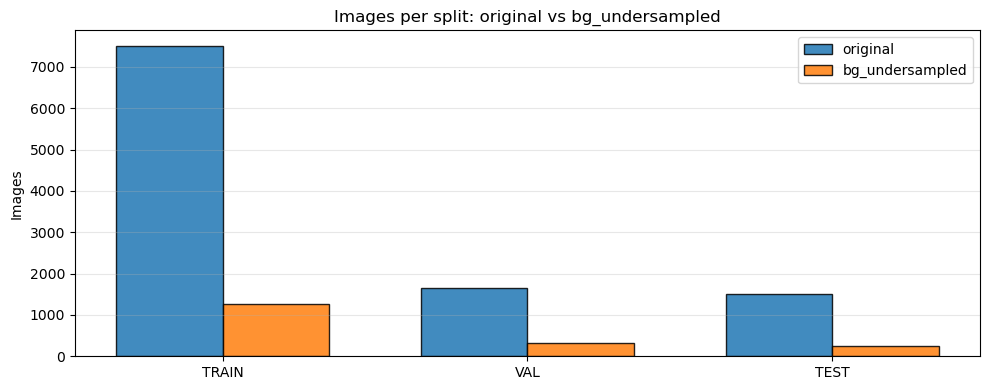

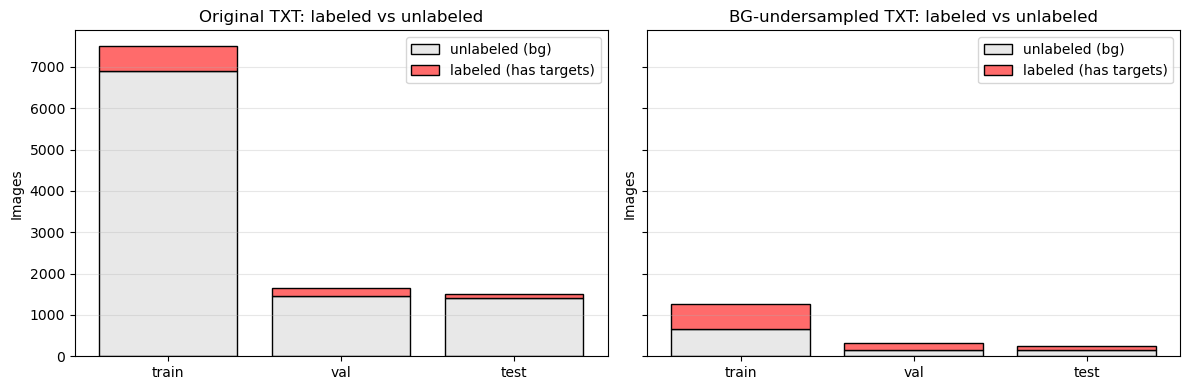

In [12]:
# Plots: original vs bg_undersampled TXT distributions
def txt_stats(txt_path: Path) -> Dict[str, float]:
    lines = txt_path.read_text(encoding="utf-8").splitlines()
    lines = [ln.strip() for ln in lines if ln.strip()]
    total = len(lines)

    labeled = 0
    label_counts: List[int] = []
    missing_images = 0

    for rel in lines:
        img_abs = _resolve_image_path(rel)
        if not img_abs.exists():
            missing_images += 1

        lbl_abs = _infer_label_path_from_image_path(rel)

        if lbl_abs.exists():
            n = len([x for x in lbl_abs.read_text(encoding="utf-8").splitlines() if x.strip()])
        else:
            n = 0

        if n > 0:
            labeled += 1
        label_counts.append(n)

    unlabeled = total - labeled

    avg_labels = float(np.mean(label_counts)) if label_counts else 0.0

    return {
        "total_images": total,
        "labeled_images": labeled,
        "unlabeled_images": unlabeled,
        "avg_labels_per_image": avg_labels,
        "missing_images": missing_images,
    }

orig_paths = {
    "train": train_txt_path,
    "val": val_txt_path,
    "test": test_txt_path,
}

us_paths = {
    "train": train_bg_us_txt_path,
    "val": val_bg_us_txt_path,
    "test": test_bg_us_txt_path,
}

orig_stats = {k: txt_stats(p) for k, p in orig_paths.items()}
us_stats = {k: txt_stats(p) for k, p in us_paths.items()}

stats_table = pd.DataFrame(
    [
        {"set": k, "variant": "original", **orig_stats[k]}
        for k in ["train", "val", "test"]
    ]
    + [
        {"set": k, "variant": "bg_undersampled", **us_stats[k]}
        for k in ["train", "val", "test"]
    ]
)

display(stats_table)

# Plot 1: total images per split

plt.figure(figsize=(10, 4))
x = np.arange(3)
width = 0.35
splits = ["train", "val", "test"]

orig_counts = [orig_stats[s]["total_images"] for s in splits]
us_counts = [us_stats[s]["total_images"] for s in splits]

plt.bar(x - width/2, orig_counts, width, label="original", edgecolor="black", alpha=0.85)
plt.bar(x + width/2, us_counts, width, label="bg_undersampled", edgecolor="black", alpha=0.85)
plt.xticks(x, [s.upper() for s in splits])
plt.ylabel("Images")
plt.title("Images per split: original vs bg_undersampled")
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: labeled vs unlabeled (stacked)
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

def stacked(ax, stats_dict, title: str):
    labeled = [stats_dict[s]["labeled_images"] for s in splits]
    unlabeled = [stats_dict[s]["unlabeled_images"] for s in splits]
    ax.bar(splits, unlabeled, label="unlabeled (bg)", color="#E8E8E8", edgecolor="black")
    ax.bar(splits, labeled, bottom=unlabeled, label="labeled (has targets)", color="#FF6B6B", edgecolor="black")
    ax.set_title(title)
    ax.set_ylabel("Images")
    ax.grid(axis="y", alpha=0.3)
    ax.legend()

stacked(axes[0], orig_stats, "Original TXT: labeled vs unlabeled")
stacked(axes[1], us_stats, "BG-undersampled TXT: labeled vs unlabeled")
plt.tight_layout()
plt.show()


## Visualize Split Distribution

Create bar plots and pie charts to verify proper stratification across splits.

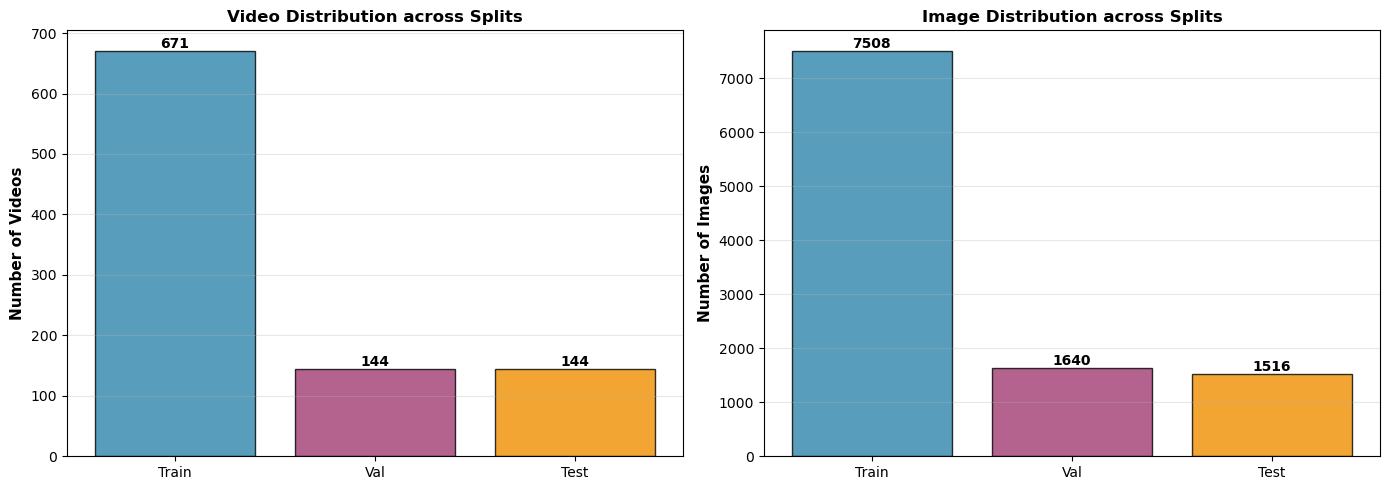

Counts:
  Train : 671 videos, 7508 images
  Val   : 144 videos, 1640 images
  Test  : 144 videos, 1516 images


In [13]:
# Visualization 1: Video Distribution across splits
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

splits = ['Train', 'Val', 'Test']
video_counts = [len(train_df), len(val_df), len(test_df)]
image_counts = [len(train_image_paths), len(val_image_paths), len(test_image_paths)]

# Videos per split
colors_splits = ['#2E86AB', '#A23B72', '#F18F01']
axes[0].bar(splits, video_counts, color=colors_splits, edgecolor='black', alpha=0.8)
axes[0].set_ylabel('Number of Videos', fontsize=11, fontweight='bold')
axes[0].set_title('Video Distribution across Splits', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(video_counts):
    axes[0].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# Images per split
axes[1].bar(splits, image_counts, color=colors_splits, edgecolor='black', alpha=0.8)
axes[1].set_ylabel('Number of Images', fontsize=11, fontweight='bold')
axes[1].set_title('Image Distribution across Splits', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(image_counts):
    axes[1].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print('Counts:')
for split, videos, images in zip(splits, video_counts, image_counts):
    print(f'  {split:6s}: {videos:3d} videos, {images:4d} images')


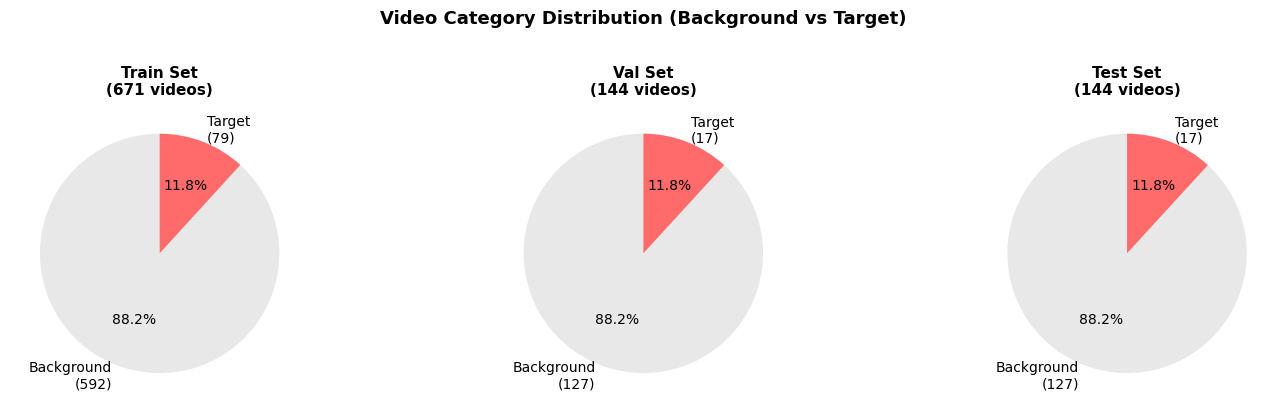

In [14]:
# Visualization 2: Background vs Target video distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

split_dfs = [train_df, val_df, test_df]
split_names = ['Train', 'Val', 'Test']

for idx, (split_df, split_name, ax) in enumerate(zip(split_dfs, split_names, axes)):
    bg_count = (split_df['video_category'] == 'background').sum()
    tg_count = (split_df['video_category'] == 'target').sum()
    
    sizes = [bg_count, tg_count]
    labels = [f'Background\n({bg_count})', f'Target\n({tg_count})']
    colors = ['#E8E8E8', '#FF6B6B']
    
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10})
    ax.set_title(f'{split_name} Set\n({len(split_df)} videos)', fontsize=11, fontweight='bold')

plt.suptitle('Video Category Distribution (Background vs Target)', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


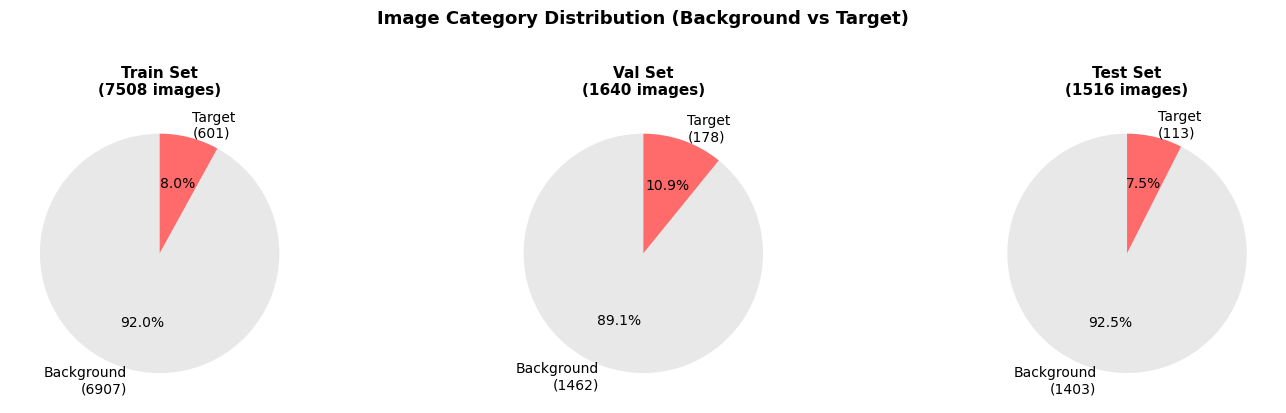

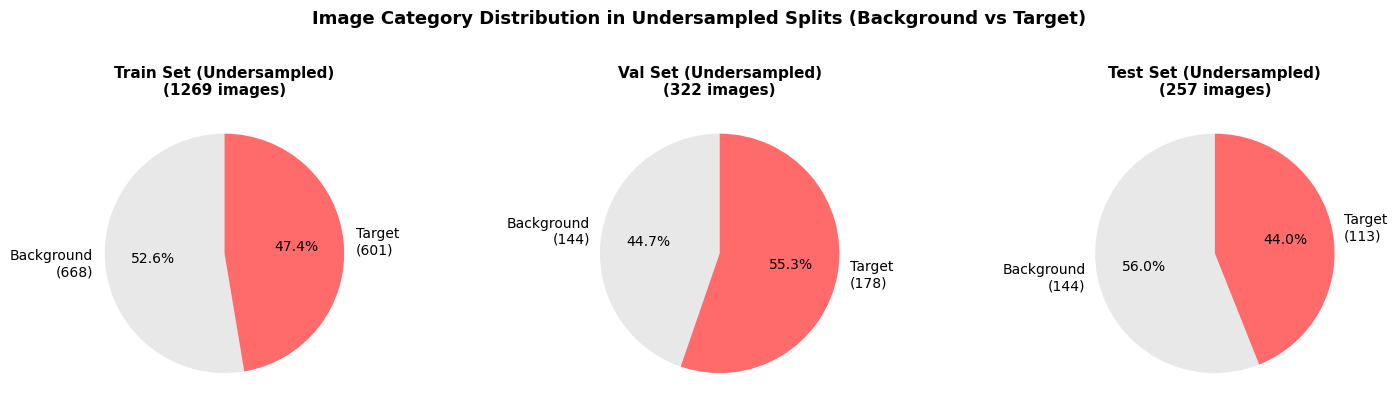

In [15]:
# Visualization of image category distribution across splits
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
split_dfs = [train_images_full_df, val_images_full_df, test_images_full_df]
split_names = ['Train', 'Val', 'Test']
for idx, (split_df, split_name, ax) in enumerate(zip(split_dfs, split_names, axes)):
    bg_count = (split_df['frame_num_targets'] == 0).sum()
    tg_count = (split_df['frame_num_targets'] > 0).sum()
    
    sizes = [bg_count, tg_count]
    labels = [f'Background\n({bg_count})', f'Target\n({tg_count})']
    colors = ['#E8E8E8', '#FF6B6B']
    
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10})
    ax.set_title(f'{split_name} Set\n({len(split_df)} images)', fontsize=11, fontweight='bold')
plt.suptitle('Image Category Distribution (Background vs Target)', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
split_dfs_us = [train_bg_us_df, val_bg_us_df, test_bg_us_df]
split_names = ['Train', 'Val', 'Test']
for idx, (split_df, split_name, ax) in enumerate(zip(split_dfs_us, split_names, axes)):
    bg_count = 0
    tg_count = 0
    for img_path in split_df['image_path']:
        lbl_path = _infer_label_path_from_image_path(img_path)
        classes = _read_yolo_classes(lbl_path)
        if len(classes) == 0:
            bg_count += 1
        else:
            tg_count += 1
    
    sizes = [bg_count, tg_count]
    labels = [f'Background\n({bg_count})', f'Target\n({tg_count})']
    colors = ['#E8E8E8', '#FF6B6B']
    
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10})
    ax.set_title(f'{split_name} Set (Undersampled)\n({len(split_df)} images)', fontsize=11, fontweight='bold')
plt.suptitle('Image Category Distribution in Undersampled Splits (Background vs Target)', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

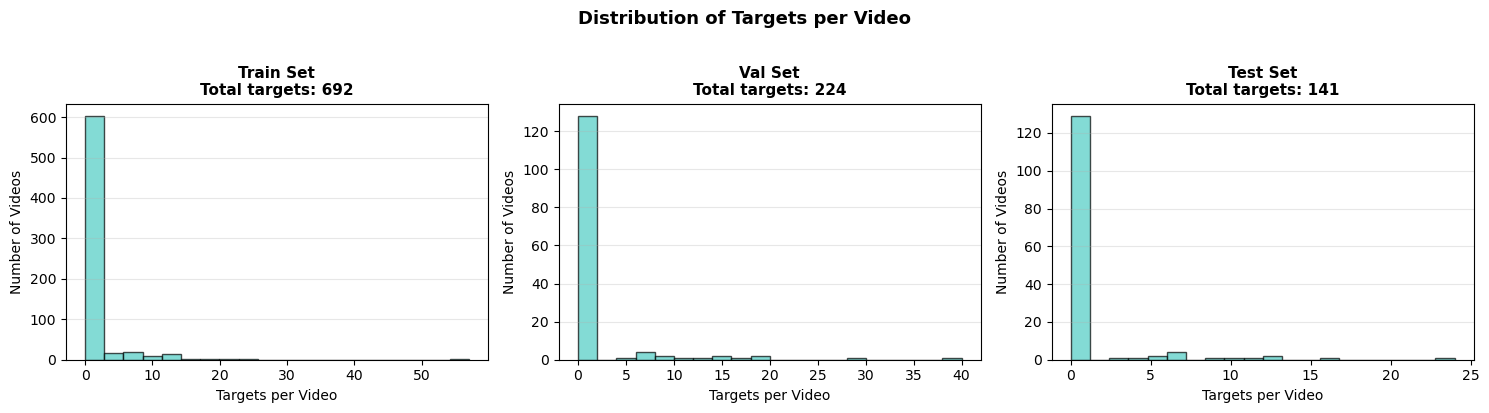

In [16]:
# Visualization 3: Target count distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

split_dfs = [train_df, val_df, test_df]
split_names = ['Train', 'Val', 'Test']

for idx, (split_df, split_name, ax) in enumerate(zip(split_dfs, split_names, axes)):
    total_targets = split_df['total_targets'].sum()
    
    # Create histogram of targets per video
    ax.hist(split_df['total_targets'], bins=20, color='#4ECDC4', edgecolor='black', alpha=0.7)
    ax.set_xlabel('Targets per Video', fontsize=10)
    ax.set_ylabel('Number of Videos', fontsize=10)
    ax.set_title(f'{split_name} Set\nTotal targets: {int(total_targets)}', fontsize=11, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Distribution of Targets per Video', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


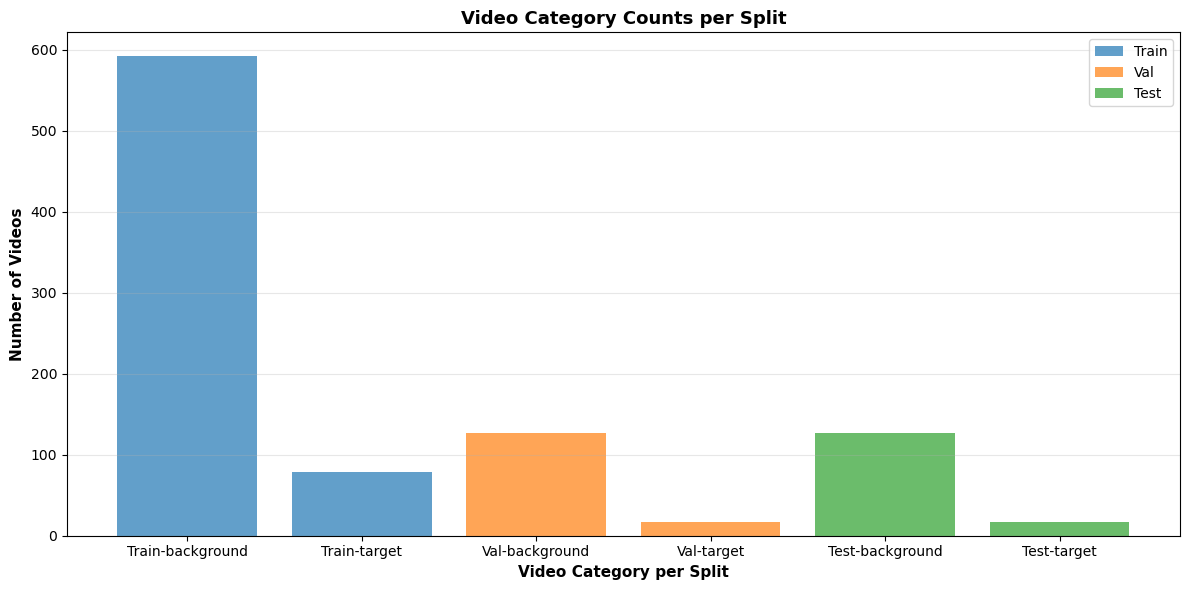

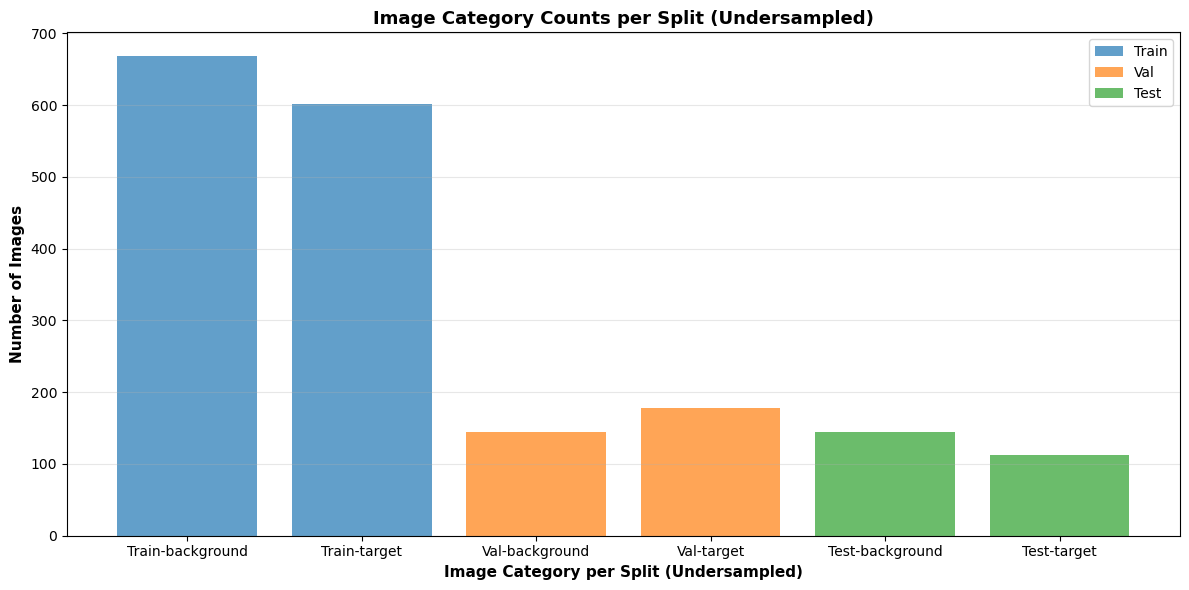

In [17]:
# Show number per class per video per split
plt.figure(figsize=(12, 6))
split_dfs = [train_df, val_df, test_df]
split_names = ['Train', 'Val', 'Test']
for split_df, split_name in zip(split_dfs, split_names):
    class_counts = defaultdict(int)
    for _, row in split_df.iterrows():
        category = row['video_category']
        class_counts[category] += 1
    
    categories = list(class_counts.keys())
    counts = [class_counts[cat] for cat in categories]
    
    plt.bar([f'{split_name}-{cat}' for cat in categories], counts, alpha=0.7, label=split_name)
plt.xlabel('Video Category per Split', fontsize=11, fontweight='bold')
plt.ylabel('Number of Videos', fontsize=11, fontweight='bold')
plt.title('Video Category Counts per Split', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Undersampled
plt.figure(figsize=(12, 6))
split_dfs_us = [train_bg_us_df, val_bg_us_df, test_bg_us_df]
split_names = ['Train', 'Val', 'Test']
for split_df, split_name in zip(split_dfs_us, split_names):
    class_counts = defaultdict(int)
    for img_path in split_df['image_path']:
        lbl_path = _infer_label_path_from_image_path(img_path)
        classes = _read_yolo_classes(lbl_path)
        if len(classes) == 0:
            class_counts['background'] += 1
        else:
            class_counts['target'] += 1
    
    categories = list(class_counts.keys())
    counts = [class_counts[cat] for cat in categories]
    
    plt.bar([f'{split_name}-{cat}' for cat in categories], counts, alpha=0.7, label=split_name)
plt.xlabel('Image Category per Split (Undersampled)', fontsize=11, fontweight='bold')
plt.ylabel('Number of Images', fontsize=11, fontweight='bold')
plt.title('Image Category Counts per Split (Undersampled)', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
# Summary
print('\n' + '='*80)
print('DATASET SPLIT COMPLETE')
print('='*80)
print(f'\nCSV files created in: {CSV_OUTPUT_DIR}')
print(f'\nSplit Summary:')
print(f'  Train: {len(train_df):3d} videos, {len(train_image_paths):4d} images (70%)')
print(f'  Val:   {len(val_df):3d} videos, {len(val_image_paths):4d} images (15%)')
print(f'  Test:  {len(test_df):3d} videos, {len(test_image_paths):4d} images (15%)')
print(f'  ─────────────────────────────────────')
print(f'  Total: {len(df_videos):3d} videos, {len(df_images):4d} images')

print(f'\nStratification maintained:')
overall_bg = (df_videos['video_category'] == 'background').sum() / len(df_videos) * 100
overall_tg = (df_videos['video_category'] == 'target').sum() / len(df_videos) * 100
print(f'  Overall:  BG={overall_bg:5.1f}%, TG={overall_tg:5.1f}%')
train_bg = (train_df['video_category'] == 'background').sum() / len(train_df) * 100 if len(train_df) > 0 else 0
train_tg = (train_df['video_category'] == 'target').sum() / len(train_df) * 100 if len(train_df) > 0 else 0
val_bg = (val_df['video_category'] == 'background').sum() / len(val_df) * 100 if len(val_df) > 0 else 0
val_tg = (val_df['video_category'] == 'target').sum() / len(val_df) * 100 if len(val_df) > 0 else 0
test_bg = (test_df['video_category'] == 'background').sum() / len(test_df) * 100 if len(test_df) > 0 else 0
test_tg = (test_df['video_category'] == 'target').sum() / len(test_df) * 100 if len(test_df) > 0 else 0
print(f'  Train:    BG={train_bg:5.1f}%, TG={train_tg:5.1f}%')
print(f'  Val:      BG={val_bg:5.1f}%, TG={val_tg:5.1f}%')
print(f'  Test:     BG={test_bg:5.1f}%, TG={test_tg:5.1f}%')

print(f'\nKey guarantees:')
print(f'  ✓ Video-level grouping: All frames from same video stay together')
print(f'  ✓ Stratified split: Background/target ratio maintained across splits')
print(f'  ✓ No duplicates: Each image appears in exactly one split')
print(f'  ✓ Complete coverage: All {len(df_images)} images are included')


DATASET SPLIT COMPLETE

CSV files created in: /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/splits

Split Summary:
  Train: 671 videos, 7508 images (70%)
  Val:   144 videos, 1640 images (15%)
  Test:  144 videos, 1516 images (15%)
  ─────────────────────────────────────
  Total: 959 videos, 10664 images

Stratification maintained:
  Overall:  BG= 88.2%, TG= 11.8%
  Train:    BG= 88.2%, TG= 11.8%
  Val:      BG= 88.2%, TG= 11.8%
  Test:     BG= 88.2%, TG= 11.8%

Key guarantees:
  ✓ Video-level grouping: All frames from same video stay together
  ✓ Stratified split: Background/target ratio maintained across splits
  ✓ No duplicates: Each image appears in exactly one split
  ✓ Complete coverage: All 10664 images are included


In [21]:
# put test and val together and save as txt
combined_val_test_df = pd.concat([val_csv_df, test_csv_df]).reset_index(drop=True)
combined_val_test_path = CSV_OUTPUT_DIR / "val_test.txt"
combined_val_test_df.to_csv(combined_val_test_path, index=False, header=False)

# bg_undersampled variant
combined_val_test_bg_us_df = pd.concat([val_bg_us_df, test_bg_us_df]).reset_index(drop=True)
combined_val_test_bg_us_path = CSV_OUTPUT_DIR / "val_test_bg_undersampled.txt"
combined_val_test_bg_us_df.to_csv(combined_val_test_bg_us_path, index=False, header=False)

print(f"✓ Saved: {combined_val_test_path} ({len(combined_val_test_df)} rows)")
print(f"✓ Saved: {combined_val_test_bg_us_path} ({len(combined_val_test_bg_us_df)} rows)")

✓ Saved: /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/splits/val_test.txt (3156 rows)
✓ Saved: /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/splits/val_test_bg_undersampled.txt (579 rows)


In [22]:
# Sanity-check TXT files (original + bg_undersampled)
def _ensure_helpers_for_checks():
    # If someone runs this cell standalone after a kernel restart, define minimal helpers.
    if "_resolve_image_path" not in globals():
        def _resolve_image_path(p: str) -> Path:
            pth = Path(p)
            return pth if pth.is_absolute() else (BASE_DIR / pth)
        globals()["_resolve_image_path"] = _resolve_image_path

    if "_infer_label_path_from_image_path" not in globals():
        def _infer_label_path_from_image_path(image_path: str) -> Path:
            img_abs = globals()["_resolve_image_path"](image_path)
            lbl_abs = img_abs.with_suffix(".txt")
            lbl_abs = Path(str(lbl_abs).replace("\\images\\", "\\labels\\").replace("/images/", "/labels/"))
            return lbl_abs

        globals()["_infer_label_path_from_image_path"] = _infer_label_path_from_image_path

_ensure_helpers_for_checks()

def txt_quick_stats(txt_path: Path) -> dict:
    lines = txt_path.read_text(encoding="utf-8").splitlines()
    lines = [ln.strip() for ln in lines if ln.strip()]
    missing_images = 0
    label_counts: List[int] = []
    class_ids: List[int] = []

    for rel in lines:
        img_abs = _resolve_image_path(rel)
        if not img_abs.exists():
            missing_images += 1

        lbl_abs = _infer_label_path_from_image_path(rel)
        if lbl_abs.exists():
            raw = [x.strip() for x in lbl_abs.read_text(encoding="utf-8").splitlines() if x.strip()]
            label_counts.append(len(raw))
            for ln in raw:
                parts = ln.split()
                if parts:
                    try:
                        class_ids.append(int(float(parts[0])))
                    except Exception:
                        pass
        else:
            label_counts.append(0)

    labeled_images = sum(1 for c in label_counts if c > 0)
    avg_labels = float(np.mean(label_counts)) if label_counts else 0.0
    class_counts = pd.Series(class_ids).value_counts().sort_index().to_dict() if class_ids else {}

    return {
        "lines": len(lines),
        "missing_images": missing_images,
        "labeled_images": labeled_images,
        "avg_labels_per_image": avg_labels,
        "class_counts": class_counts,
    }

def print_stats(name: str, p: Path) -> None:
    st = txt_quick_stats(p)
    print(f"{name}: {p.name}")
    print(f"  lines(total images): {st['lines']}")
    print(f"  missing images:      {st['missing_images']}")
    print(f"  labeled images:      {st['labeled_images']}")
    print(f"  avg labels/image:    {st['avg_labels_per_image']:.3f}")
    print(f"  class counts:        {st['class_counts']}")

print("\n" + "=" * 80)
print("TXT SANITY CHECKS")
print("=" * 80)

print_stats("TRAIN original", train_txt_path)
print_stats("VAL original", val_txt_path)
print_stats("TEST original", test_txt_path)
print()
print_stats("TRAIN bg_undersampled", train_bg_us_txt_path)
print_stats("VAL bg_undersampled", val_bg_us_txt_path)
print_stats("TEST bg_undersampled", test_bg_us_txt_path)



TXT SANITY CHECKS
TRAIN original: train.txt
  lines(total images): 7508
  missing images:      0
  labeled images:      601
  avg labels/image:    0.092
  class counts:        {0: 6, 1: 393, 2: 33, 4: 114, 5: 5, 6: 141}
VAL original: val.txt
  lines(total images): 1640
  missing images:      0
  labeled images:      178
  avg labels/image:    0.137
  class counts:        {0: 40, 1: 34, 4: 58, 5: 29, 6: 63}
TEST original: test.txt
  lines(total images): 1516
  missing images:      0
  labeled images:      113
  avg labels/image:    0.093
  class counts:        {1: 31, 2: 8, 4: 62, 5: 5, 6: 35}

TRAIN bg_undersampled: train_bg_undersampled.txt
  lines(total images): 1269
  missing images:      0
  labeled images:      601
  avg labels/image:    0.545
  class counts:        {0: 6, 1: 393, 2: 33, 4: 114, 5: 5, 6: 141}
VAL bg_undersampled: val_bg_undersampled.txt
  lines(total images): 322
  missing images:      0
  labeled images:      178
  avg labels/image:    0.696
  class counts:     